## plot_tc_wind.ipynb
Author: Robert M. Frost

University of Oklahoma

Created 23 August 2023

Purpose: Plot timeseries of maximum wind at different vertical levels of WRF TC simulation following the TC track

In [2]:
import sys
sys.path.append("/home/robbyfrost/jhr-wrf-python/")
from mask_tc_track import mask_tc_track
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from netCDF4 import Dataset
import wrf
from wrf import getvar

read in stitched output and extract necessary arrays

In [3]:
# read in stitched output
ds = xr.open_dataset("/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_erin/stitchd02_wrfout.nc")

# read in plev interpolated values
u_c = xr.open_dataset("/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_erin/analysis/c_ncp_interp_U").U
v_c = xr.open_dataset("/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_erin/analysis/c_ncp_interp_V").V
u_d = xr.open_dataset("/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_erin/analysis/d_ncp_interp_U").U
v_d = xr.open_dataset("/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_erin/analysis/d_ncp_interp_V").V

In [4]:
u_c["bottom_top"] = np.arange(1000,500,-50)
u_d["bottom_top"] = np.arange(1000,500,-50)
v_c["bottom_top"] = np.arange(1000,500,-50)
u_d["bottom_top"] = np.arange(1000,500,-50)

In [5]:
# u10 = ds.U10
# v10 = ds.V10

In [6]:
lat = ds.XLAT[0].values
lon = ds.XLONG[0].values
time = ds.XTIME

expand and reorder dimensions to fit mask_tc_track function

In [7]:
# u10 = u10.expand_dims(dim={"z":1})
# u10 = u10.transpose("Time", "z", "south_north", "west_east")
# v10 = v10.expand_dims(dim={"z":1})
# v10 = v10.transpose("Time", "z", "south_north", "west_east")

read in tc track, mask to follow track

In [8]:
# read in simulated tc track
sim_track = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_erin/erin3000mtrack_rvor.nc"
# mask dataset to follow tc track
uc_mask = mask_tc_track(track_file=sim_track, rmax=1, var=u_c, 
                        lon_tmp=lon, lat=lat, t0=0, t1=61)
ud_mask = mask_tc_track(track_file=sim_track, rmax=1, var=u_d, 
                        lon_tmp=lon, lat=lat, t0=0, t1=61)
vc_mask = mask_tc_track(track_file=sim_track, rmax=1, var=v_c, 
                        lon_tmp=lon, lat=lat, t0=0, t1=61)
vd_mask = mask_tc_track(track_file=sim_track, rmax=1, var=v_d, 
                        lon_tmp=lon, lat=lat, t0=0, t1=61)

/home/robbyfrost/jhr-wrf-python/mask_tc_track.py:68: RuntimeWarning: overflow encountered in square
  radius3d = np.sqrt( lon3d**2 + lat3d**2 )
/home/robbyfrost/jhr-wrf-python/mask_tc_track.py:68: RuntimeWarning: invalid value encountered in sqrt
  radius3d = np.sqrt( lon3d**2 + lat3d**2 )


calculate masked windspeed

In [9]:
# wspd10 = (u10_mask ** 2 + v10_mask ** 2) ** (1/2)
wspd_c = (uc_mask ** 2 + vc_mask ** 2) ** (1/2)
wspd_d = (ud_mask ** 2 + vd_mask ** 2) ** (1/2)

/home/robbyfrost/miniconda3/lib/python3.10/site-packages/numpy/ma/core.py:6975: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


extract positional coordinates

In [10]:
y = ds.south_north
x = ds.west_east

find max wspd in tc track mask for each timestep

In [11]:
# wspd10_max = np.empty(time.size)
wspd_c_max = np.empty((time.size, wspd_c[0,:,0,0].size))
wspd_d_max = np.empty((time.size, wspd_d[0,:,0,0].size))

for jt in range(time.size):
    # wspd10_max[jt] = np.max(wspd10[jt], axis=(1,2))
    for jz in range(wspd_c[0,:,0,0].size):
        wspd_c_max[jt,jz] = np.max(wspd_c[jt,jz], axis=(0,1))
        wspd_d_max[jt,jz] = np.max(wspd_d[jt,jz], axis=(0,1))

/tmp/ipykernel_37303/3737086382.py:8: UserWarning: Warning: converting a masked element to nan.
  wspd_c_max[jt,jz] = np.max(wspd_c[jt,jz], axis=(0,1))
/tmp/ipykernel_37303/3737086382.py:9: UserWarning: Warning: converting a masked element to nan.
  wspd_d_max[jt,jz] = np.max(wspd_d[jt,jz], axis=(0,1))


plotting set up

In [12]:
# plotting setup
rc('font',weight='normal',size=12.5)
# rc('text',usetex='True')
rc('figure',facecolor='white')
import seaborn
colors = seaborn.color_palette("rocket", 6)

plot timeseries of max wspd

(0.0, 80.0)

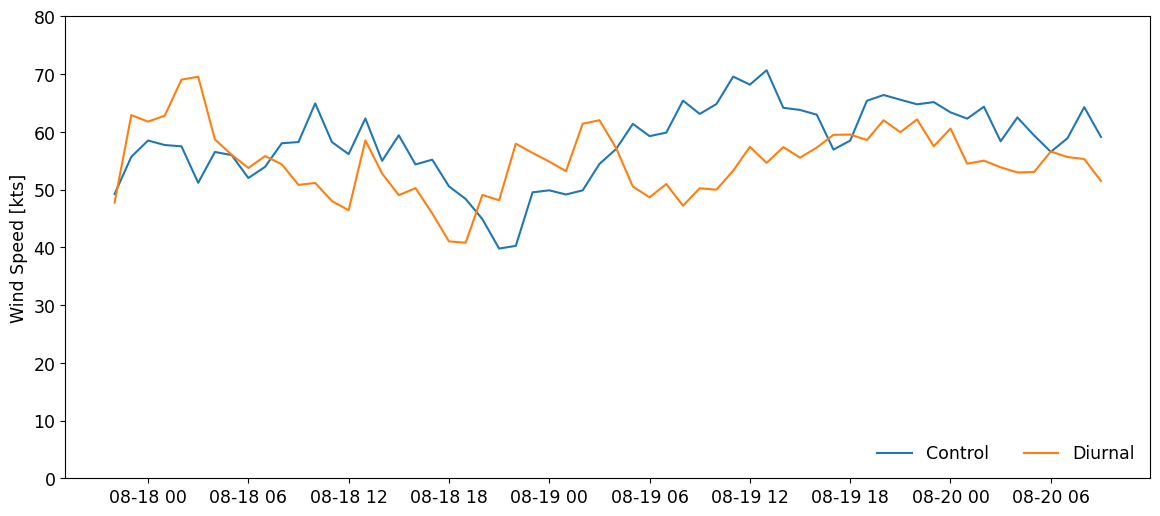

In [13]:
fig, ax = plt.subplots(figsize=(14,6))

ax.plot(time, wspd_c_max[:,3] * 1.944, label="Control")#, c=colors[0])
ax.plot(time, wspd_d_max[:,3] * 1.944, label="Diurnal")

ax.set_ylabel("Wind Speed [kts]")

ax.legend(frameon=False, ncol=2, loc="lower right")
ax.set_ylim(0,80)

# ax.set_title("TS Erin Control Case")

In [21]:
np.argmax(wspd_c_max[1:,3])

39

plot cross section of masked wspd with wind barbs

Text(0.5, 1.0, '850 mb')

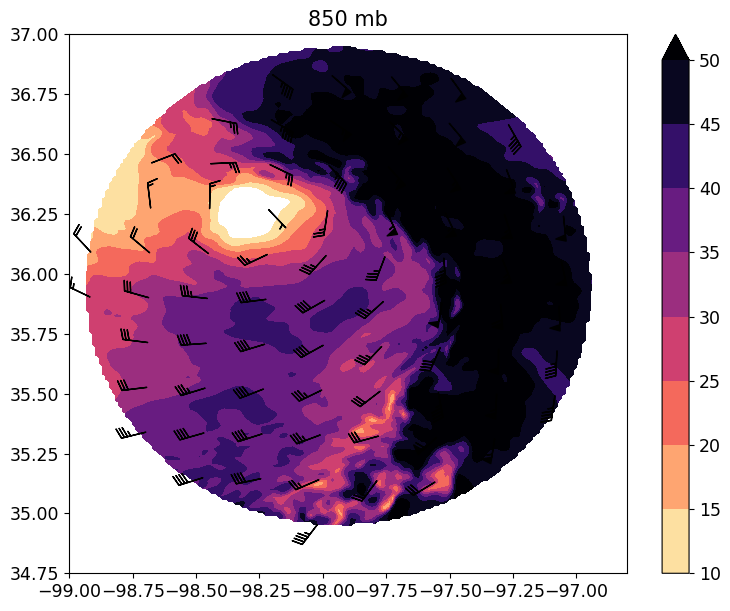

In [32]:
clevs = np.arange(10,51,5)

fig, ax = plt.subplots(figsize=(9,7))

c = ax.contourf(lon, lat, wspd_c[39,3] * 1.944, clevs, cmap="magma_r", extend="max")

# Wind barbs
spacing=17 #barbspacing (smaller if zoomed in)
ax.barbs(lon[::spacing,::spacing], lat[::spacing,::spacing],
            uc_mask[39,3,::spacing,::spacing] * 1.944, vc_mask[39,3,::spacing,::spacing] * 1.944, 
            length=6)

cbar = fig.colorbar(c)

ax.set_xlim(-99,-96.8)
ax.set_ylim(34.75,37)

ax.set_title(f"{u_c.bottom_top[3].values} mb")